In [88]:
from __future__ import print_function
from collections import Counter
from collections import OrderedDict
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import calendar
import datetime
import re
from math import log
from scipy import stats
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from array import array

In [2]:
#load the pickle object for quick access
result = pd.read_pickle("/Users/Matt/Documents/Stevens/BIA660 Web Analytics/yelp_dataset_challenge_academic_dataset/Data/500_Dataset")

In [3]:
result.head()

,business_id,date,review_id,stars_x,text,type_x,user_id,votes,attributes,categories,...,hours,latitude,longitude,name,neighborhoods,open,review_count,stars_y,state,type_y
0,mpDxBBGywUE6GRRKja3sBA,2005-09-06,HtqQG2umwuVGbMbHapBm-A,4,"Upscale soul food. Cornbread, fried chicken, ...",review,Puv7uq6Wx4AtL_jVpC4d3w,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
1,mpDxBBGywUE6GRRKja3sBA,2006-03-02,WIe91sMuGkxvPTEBXyIyrQ,4,Cornbread and Sweet Tea. If that was all you a...,review,3Gazlt5RwZQIu1ZWMwi0cg,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
2,mpDxBBGywUE6GRRKja3sBA,2006-11-07,BPZqNCPQz-EC2AOi9WLrEQ,3,This place is ok. It can be crowded (meaning ...,review,K5dxGhJ99TmS6La6krwkcg,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
3,mpDxBBGywUE6GRRKja3sBA,2007-05-24,QNa7UGC5R_yLY7oJpWQs-Q,4,I think that this place is worth going to just...,review,AJtc4UMsCDw8QJQMyfHa_w,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
4,mpDxBBGywUE6GRRKja3sBA,2007-09-25,S9g5NqdkuU28C6XW0aBd0g,4,"Ah Mert's! I love this place! It's not fancy, ...",review,bxGekdRVUysLtZ4BYF8wEQ,"{u'funny': 0, u'useful': 1, u'cool': 1}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business


In [4]:
def exploreBusiness(businessID):
    #exploratory Analysis for business ID mpDxBBGywUE6GRRKja3sBA
    business1 = result[result["business_id"]==businessID]
    #change date into datetime
    business1['date'] = pd.to_datetime(business1['date'])
    business1['Year-Month'] = business1.date.map(lambda x: x.strftime('%Y-%m'))
    business1['Qdate'] = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.QuarterEnd() for date in business1.date]
    #review_counts = business1.groupby('Year-Month')['review_id'].count()
    review_counts = business1.groupby('Year-Month')['stars_x'].count()
    ax = review_counts.plot(kind='bar', figsize=(20,10))
    return review_counts, business1

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

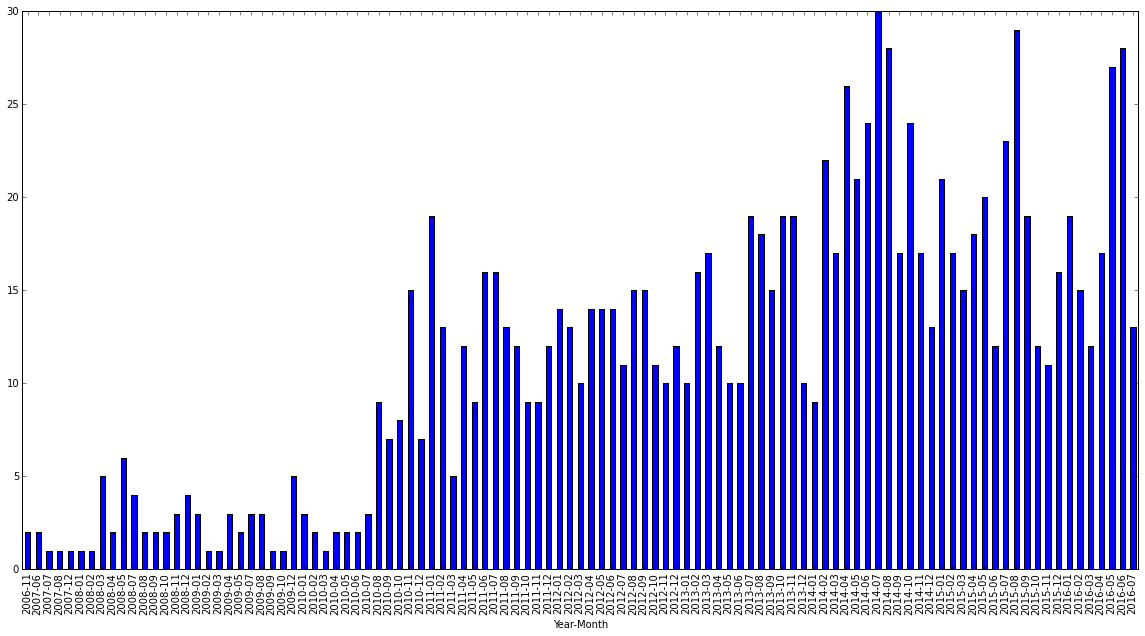

In [135]:
review_counts, business_df = exploreBusiness('3Q0QQPnHcJuX1DLCL9G9Cg')
#review_counts, business_df = exploreBusiness('Pgp3gbOQaJIdyjqC9AOz6g')


In [226]:
# runs a 1 sample t test to compare a new month with the previous months
# https://stats.stackexchange.com/questions/198825/compare-previous-month-to-all-other-previous-months-performance
# http://iaingallagher.tumblr.com/post/50980987285/t-tests-in-python
def Ttest(review_counts):
    anomaly = OrderedDict() #initialize dict
    d = OrderedDict()
    for ind, value in review_counts.iteritems():
        d[ind] = value
        #anomaly[ind]=-1
        if len(d) >= 31: #need 30 samples because the data is non-normal
            #t-test to compare the next month/year sample to the mean of all the prior ones
            one_sample_data = d.values()[0:(len(d)-1)]
            one_sample = stats.ttest_1samp(one_sample_data,value) #compares the entire period
            #print(ind,value, one_sample_data)
            #print(len(d))
            if one_sample.pvalue < 0.01: #null hypothesis: new sample = prior mean
                anomaly[ind]=1  #there is a statistically signifant difference, where the new sample != prior mean   
    return anomaly

In [146]:
#locate the period where there is a change in the anomaly[ind] values
#returns a dict where an anomaly is coded as a 1
def choosePeriods(anomaly):
    period={}
    keylist = anomaly.keys()
    keylist.sort()
    for key in keylist:
        if anomaly[key] == 1:
            period[key]=1
        else:
            period[key]=0
    return period   

In [244]:
#show a summary of the top words of ALL the anomalies for a given business
def getCommonWordsSummary(business_df, business_id, period):
    common={}
    final=''
    keylist = period.keys()
    keylist.sort()
    words_test=[]
    for key in keylist:
        if period[key] == 1:
            text=business_df[(business_df['Year-Month']==key)].text
            text=text.to_string()
            text = re.sub('\W+', ' ',text)
            default_stopwords = set(nltk.corpus.stopwords.words('english'))
            custom_stopwords = set((u'–', '...'))
            all_stopwords = default_stopwords | custom_stopwords
            words = nltk.word_tokenize(text)

            words = [word for word in words if len(word) > 2] #remove words that are only 1 character
            # Remove numbers
            words = [word for word in words if not word.isnumeric()]

            # Lowercase all words (default_stopwords are lowercase too)
            words = [word.lower() for word in words]

            #remove words that are stopwords
            words = [word for word in words if word not in all_stopwords]
            words_test += words

    #print(words_test)
    # Calculate frequency distribution
    fdist = nltk.FreqDist(words_test)

    for word, frequency in fdist.most_common(10):
        final+=str(word+' ')
    common[business_id] = final

    return common

In [245]:
#outputs the most common words for each anomaly found for a business
def getCommonWordsForEachAnomaly(business_df, business_id, period):
    common={}
    keylist = period.keys()
    keylist.sort()
    for key in keylist:
        final=''
        if period[key] == 1:
            text=business_df[(business_df['Year-Month']==key)].text
            text=text.to_string()
            text = re.sub('\W+', ' ',text)
            default_stopwords = set(nltk.corpus.stopwords.words('english'))
            custom_stopwords = set((u'–', '...'))
            all_stopwords = default_stopwords | custom_stopwords
            words = nltk.word_tokenize(text)
            
            words = [word for word in words if len(word) > 2] #remove words that are only 1 character
            # Remove numbers
            words = [word for word in words if not word.isnumeric()]

            # Lowercase all words (default_stopwords are lowercase too)
            words = [word.lower() for word in words]

            #remove words that are stopwords
            words = [word for word in words if word not in all_stopwords]

            # Calculate frequency distribution
            fdist = nltk.FreqDist(words)
            
            for word, frequency in fdist.most_common(5):
                final+=str(word+' ')
        common[key] = final
    
    return business_id, common

In [242]:
anomaly=Ttest(review_counts)
period= choosePeriods(anomaly)
getCommonWordsForEachAnomaly(business_df,'3Q0QQPnHcJuX1DLCL9G9Cg',period)

('3Q0QQPnHcJuX1DLCL9G9Cg',
 {'2009-06': 'great service paying atmosphere food ',
  '2009-07': 'people food great many meal ',
  '2009-08': 'tao vegas place must crazy ',
  '2009-10': 'tao great dining atmosphere give ',
  '2009-11': 'restaurant tao club went 30th ',
  '2010-01': 'dinner night tao friday decid ',
  '2010-02': 'ever food best went beautiful ',
  '2010-04': 'food ambiance tao place beautiful ',
  '2010-05': 'food atmosphere place vegas love ',
  '2010-06': 'went dinner int another strip ',
  '2010-07': 'great place tao restaurant miso ',
  '2010-08': 'tao tar tuna best food ',
  '2010-09': 'saying atmosphere fair show missus ',
  '2010-11': 'food sea seeing vegas people ',
  '2010-12': 'nchilean good star nwhat prett ',
  '2011-01': 'dinner place went september fancy ',
  '2011-03': 'like tao food time process ',
  '2011-04': 'tao time food place every ',
  '2011-05': 'tao love absolutely reservations seem ',
  '2011-06': 'reservations friend skip accept cockt ',
  '2011-

In [ ]:
#summary of the common words for ALL anomalies in a business

for business in result.business_id.unique():
    common={}
    business_id = business
    review_counts, business_df = exploreBusiness(business)
    anomaly=Ttest(review_counts)
    period= choosePeriods(anomaly)
    print(getCommonWordsSummary(business_df,business_id,period))
    

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

{u'mpDxBBGywUE6GRRKja3sBA': 'food place mert soul great good charlotte best service first '}
{u'3Q0QQPnHcJuX1DLCL9G9Cg': 'airport charlotte nice airports one like clean clt easy great '}
{u'tb24fvNJfHhyKEXkKn12Xw': 'place food great diner love welcome amazing little good awesome '}
{u'qMkIbQFrROSnPaQ7at85-w': 'place desert botanical garden beautiful great went gardens visit love '}
{u'AkOruz5CrCxUmXe1p_WoRg': 'place food ramen love great good cherry blossom japanese service '}
{u'R8VwdLyvsp9iybNqRvm94g': 'place lgo love great food good breakfast grande pizza orange '}
{u'SDwYQ6eSu1htn8vHWv128g': 'place love great postino food wine bruschetta favorite good one '}
{u'hW0Ne_HTHEAgGF1rAdmR-g': 'airport sky phoenix harbor one airports terminal nice like clean '}
{u'rDvz5jX65gpfONFu7er9Tw': 'place food tacos good best mexican great love street one '}
{u'wZwZcte4lcbu51NOzCjWbQ': 'place great food view rooste atmosphere fun good went service '}
{u'L9UYbtAUOcfTgZFimehlXw': 'place food liberty l

In [185]:
#results[(results.business_id=='3Q0QQPnHcJuX1DLCL9G9Cg') && (results.date==period[key])]
#text=business_df[(business_df.business_id=='3Q0QQPnHcJuX1DLCL9G9Cg') & (business_df['Year-Month']=='2010-09')].text
